# Import what we need

In [1]:
import os, random, math, time
from pathlib import Path
import torch.nn as nn
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset ,Dataset
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input/date-fruit-image-dataset-in-controlled-environment")

dataset = ImageFolder(DATA_DIR)

print("Number of images:", len(dataset))
print("Classes:", dataset.classes)
print("Number of classes:", len(dataset.classes))

Number of images: 1658
Classes: ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']
Number of classes: 9


# Check the GPU availability

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Init the transforms

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(
        224,
        scale=(0.9, 1.0),
        ratio=(0.95, 1.05)
    ),

    transforms.ColorJitter(
        brightness=0.10,
        contrast=0.10,
        saturation=0.05,
        hue=0.0
    ),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [5]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [6]:
base_dataset = ImageFolder(DATA_DIR)
base_dataset

Dataset ImageFolder
    Number of datapoints: 1658
    Root location: /kaggle/input/date-fruit-image-dataset-in-controlled-environment

# Spliting the data to TRAIN / VAL

In [7]:
indices = np.arange(len(base_dataset))
targets = base_dataset.targets

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=targets
)

train_dataset = ImageFolder(DATA_DIR, transform=train_transform)
val_dataset   = ImageFolder(DATA_DIR, transform=val_transform)

train_dataset = Subset(train_dataset, train_idx)
val_dataset   = Subset(val_dataset, val_idx)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

Train size: 1326
Val size: 332


# Dataloader time

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

# Show sample of the data

In [9]:
class_names = dataset.classes
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


In [101]:
def unnormalize(img):
    img = img.clone().detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean
    return img

def show_images(dataset, class_names, n=6):
    plt.figure(figsize=(12, 6))

    for i in range(n):
        img, label = dataset[i]
        img = unnormalize(img)
        img = img.permute(1, 2, 0)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

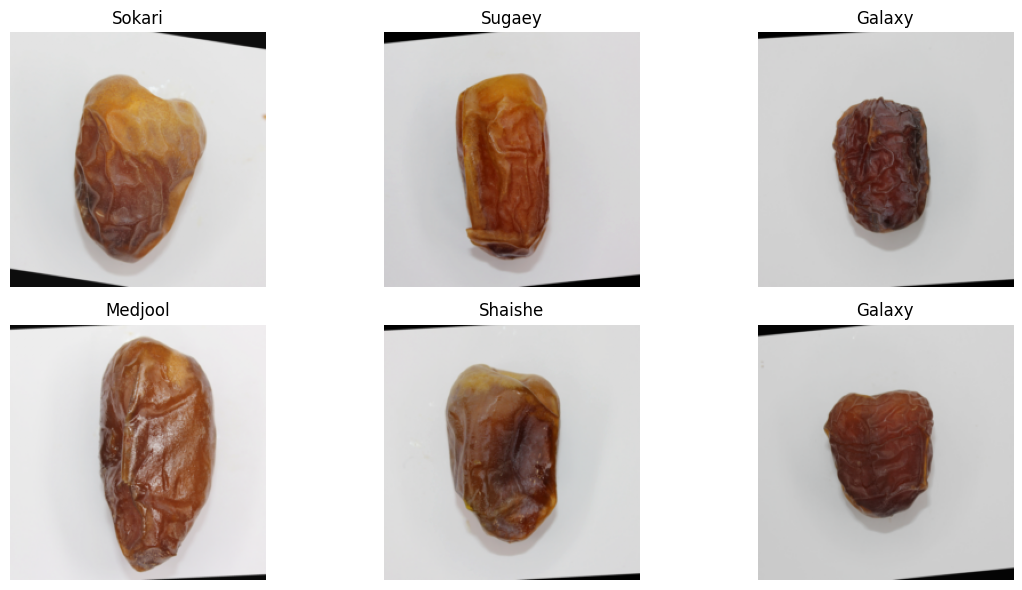

In [102]:
show_images(train_dataset, class_names, n=6)

# Download the mobilenetV3 MODEL 
# Changing the last layer

In [103]:
weights = MobileNet_V3_Small_Weights.DEFAULT
model = mobilenet_v3_small(weights=weights)

In [104]:
num_classes = 9

in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)

In [105]:
model = model.to(DEVICE)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

# Freez all the model exept the last layer

In [106]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [107]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [108]:
optimizer = torch.optim.Adam(model.classifier.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Trainig+Val Time!!

In [109]:
from tqdm import tqdm

EPOCHS = 12

for epoch in range(EPOCHS):

    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total


    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total


    print(f"""
Epoch [{epoch+1}/{EPOCHS}]
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
""")

Epoch 1/12 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.71s/it]



Epoch [1/12]
Train Loss: 1.0123 | Train Acc: 0.6931
Val   Loss: 1.0004 | Val   Acc: 0.5904



Epoch 2/12 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.76s/it]



Epoch [2/12]
Train Loss: 0.3854 | Train Acc: 0.8846
Val   Loss: 0.5803 | Val   Acc: 0.8193



Epoch 3/12 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]



Epoch [3/12]
Train Loss: 0.2802 | Train Acc: 0.9072
Val   Loss: 0.4638 | Val   Acc: 0.8705



Epoch 4/12 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.77s/it]



Epoch [4/12]
Train Loss: 0.1982 | Train Acc: 0.9434
Val   Loss: 0.3478 | Val   Acc: 0.9157



Epoch 5/12 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.73s/it]



Epoch [5/12]
Train Loss: 0.1751 | Train Acc: 0.9419
Val   Loss: 0.4571 | Val   Acc: 0.8253



Epoch 6/12 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.74s/it]



Epoch [6/12]
Train Loss: 0.2384 | Train Acc: 0.9238
Val   Loss: 0.4400 | Val   Acc: 0.8464



Epoch 7/12 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.71s/it]



Epoch [7/12]
Train Loss: 0.1626 | Train Acc: 0.9457
Val   Loss: 0.3891 | Val   Acc: 0.8735



Epoch 8/12 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.73s/it]



Epoch [8/12]
Train Loss: 0.1286 | Train Acc: 0.9578
Val   Loss: 0.6234 | Val   Acc: 0.7681



Epoch 9/12 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.75s/it]



Epoch [9/12]
Train Loss: 0.1493 | Train Acc: 0.9525
Val   Loss: 0.4468 | Val   Acc: 0.8494



Epoch 10/12 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.75s/it]



Epoch [10/12]
Train Loss: 0.1827 | Train Acc: 0.9306
Val   Loss: 0.3867 | Val   Acc: 0.8614



Epoch 11/12 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]



Epoch [11/12]
Train Loss: 0.1612 | Train Acc: 0.9495
Val   Loss: 0.3558 | Val   Acc: 0.8855



Epoch 12/12 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


Epoch [12/12]
Train Loss: 0.1637 | Train Acc: 0.9419
Val   Loss: 0.2840 | Val   Acc: 0.9006



In [110]:
from tqdm import tqdm
import torch

EXTRA_EPOCHS = 8
best_val_acc = 0.0 
start_epoch = 12     

for epoch in range(start_epoch, start_epoch + EXTRA_EPOCHS):

    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total


    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved NEW best model (val_acc={best_val_acc:.4f})")


    print(f"""
Epoch [{epoch+1}]
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
""")


Epoch 13 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


✅ Saved NEW best model (val_acc=0.8916)

Epoch [13]
Train Loss: 0.1146 | Train Acc: 0.9646
Val   Loss: 0.3524 | Val   Acc: 0.8916



Epoch 14 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


✅ Saved NEW best model (val_acc=0.9247)

Epoch [14]
Train Loss: 0.1230 | Train Acc: 0.9495
Val   Loss: 0.2381 | Val   Acc: 0.9247



Epoch 15 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.73s/it]



Epoch [15]
Train Loss: 0.1180 | Train Acc: 0.9548
Val   Loss: 0.3262 | Val   Acc: 0.8855



Epoch 16 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]



Epoch [16]
Train Loss: 0.1177 | Train Acc: 0.9608
Val   Loss: 0.4413 | Val   Acc: 0.8645



Epoch 17 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]



Epoch [17]
Train Loss: 0.1121 | Train Acc: 0.9585
Val   Loss: 0.3930 | Val   Acc: 0.8825



Epoch 18 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.71s/it]



Epoch [18]
Train Loss: 0.1534 | Train Acc: 0.9502
Val   Loss: 0.4023 | Val   Acc: 0.8735



Epoch 19 [Val]: 100%|██████████| 11/11 [00:18<00:00,  1.73s/it]



Epoch [19]
Train Loss: 0.0987 | Train Acc: 0.9706
Val   Loss: 0.2911 | Val   Acc: 0.9157



Epoch 20 [Val]: 100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


Epoch [20]
Train Loss: 0.0938 | Train Acc: 0.9691
Val   Loss: 0.4867 | Val   Acc: 0.8554



# Confusion Matrix

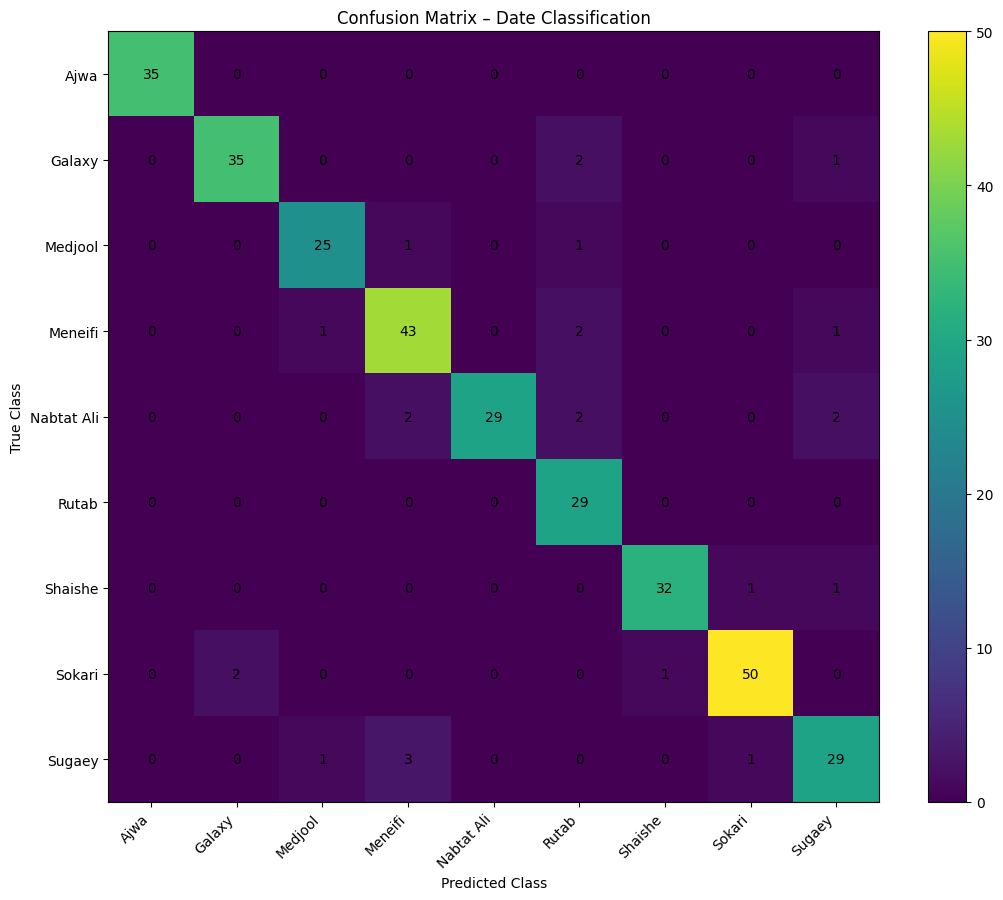

In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import mobilenet_v3_small
from sklearn.metrics import confusion_matrix
from torchvision.models import MobileNet_V3_Small_Weights

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_PATH = "/kaggle/input/date/pytorch/default/1/best_model.pth"

class_names = [
    "Ajwa",
    "Galaxy",
    "Medjool",
    "Meneifi",
    "Nabtat Ali",
    "Rutab",
    "Shaishe",
    "Sokari",
    "Sugaey"
]

num_classes = len(class_names)


model = mobilenet_v3_small(weights=None)

in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)

state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)

model.to(DEVICE)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(11, 9))
plt.imshow(cm)
plt.colorbar()
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix – Date Classification")

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

## Confusion Matrix Analysis

The confusion matrix demonstrates strong classification performance across the nine date varieties. Most predictions are concentrated along the diagonal, indicating that the model correctly classifies the majority of samples for each class.

Classes such as Ajwa, Galaxy, Rutab, and Sokari show near-perfect classification, reflecting clear visual features that the model was able to learn effectively. Minor misclassifications are observed between visually similar date types, particularly between Meneifi, Nabtat Ali, and Rutab, as well as occasional confusion involving Sugaey.

These misclassifications are expected in fine-grained image classification tasks where classes share close similarities in color, texture, and shape. Overall, the confusion matrix confirms that the model generalizes well and that the achieved accuracy is supported by consistent class-level performance rather than being biased toward specific categories.
